In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
from visdom import Visdom
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
from efficientnet_pytorch import EfficientNet
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [2]:
class mydataset(Dataset):

    #     def __init__(self, txt_file, root_dir):
    #         super(mydataset, self).__init__()
    #         with open(txt_file, 'r') as f:
    #             dataset_list = f.readlines()
    #         self.classes = {'0', '1'}
    #         self.data_list = []
    #         self.label_list = []
    #         for item in dataset_list:
    #             self.data_list.append(item.split(" ")[0])
    #             self.label_list.append(item.split(' ')[1][0])
    #         self.root_dir = root_dir

    def __init__(self, json_file, root_dir, transform=None):
        super(mydataset, self).__init__()
        labels = pd.read_json(json_file)
        self.data_list = labels.columns
        self.label_list = labels.loc['label'].tolist()
        self.root_dir = root_dir
        self.transform = transform
        self.classes=["FAKE","REAL"]

    def __len__(self):
        return len(self.data_list)*10

    def __getitem__(self, idx):
        quotient = int(idx/10)  # 商
        reminder = idx % 10  # 余数
        img = Image.open(os.path.join(
            self.root_dir, self.data_list[quotient][:-4]+"_jpg/%d.jpg" % ((reminder+1)*10)))  # 连续帧
        data = self.transform(img)
        if self.label_list[quotient]=='FAKE':
            label = 0
        else:
            label = 1
        #label = self.label_list[quotient]
        return (data, label)

In [3]:
# 训练集数据扩充和归一化
# 在验证集上仅需要归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(300),
        transforms.Resize(300),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(300),
        transforms.Resize(300),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '../../../data2/pbw_dfdc/example'
data_dir = '../../../data2/pbw_dfdc/train/'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                          data_transforms[x])
#                  for x in ['train', 'val']}
image_datasets = {'train': datasets.ImageFolder("/data2/pbw_dfdc/experiment_2/discrete/train/",data_transforms['train']),
                  'val':datasets.ImageFolder("/data2/pbw_dfdc/experiment_2/discrete/val/",data_transforms['val'])}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4,drop_last=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

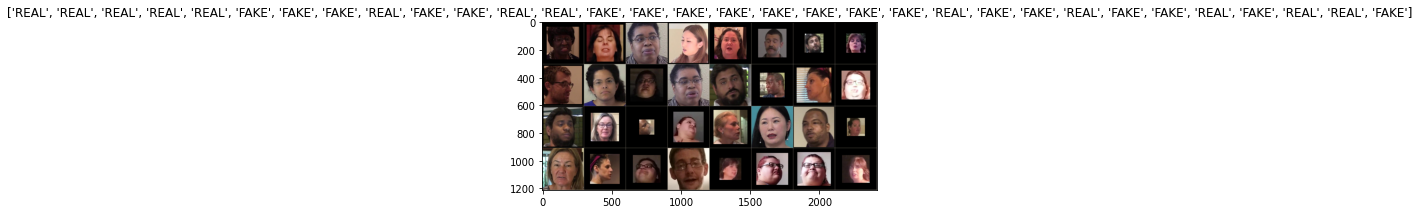

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# print(inputs.shape)
# print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 将窗口类实例化
    viz = Visdom()
    # 创建窗口并初始化
    viz.line([[0., 0.]], [0], win='discrete_train_val_loss', opts=dict(
        title='discrete_train_val_loss', legend=['train_loss', 'val_loss']))
    viz.line([[0., 0.]], [0], win='discrete_train_val_acc', opts=dict(
        title='discrete_train_val_acc', legend=['train_acc', 'val_acc']))
    train_i=0
    val_i=0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据.
            # running_loss=0
            # running_corrects=0
            # des_dict={"running_loss":running_loss,"running_corrects":running_corrects}
            
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向+仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # scheduler.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # des_dict={"running_loss":running_loss,"running_corrects":running_corrects}
                
                if phase == 'train':
                    train_i+=1
                    if train_i%50==0:
                        viz.line([[float(running_loss)/float(train_i*32)]],[train_i], win='discrete_train_val_loss',name='train_loss', update='append')
                        viz.line([[float(running_corrects)/float((train_i*32))]],[train_i], win='discrete_train_val_acc',name='train_acc', update='append')
                if phase == 'val':
                    val_i+=1
                    if val_i%50==0:
                        viz.line([[float(running_loss)/float(val_i*32)]],[val_i*7.75], win='discrete_train_val_loss',name='val_loss', update='append')
                        viz.line([[float(running_corrects)/float((val_i*32))]],[val_i*7.75],win='discrete_train_val_acc',name='val_acc', update='append')
                #print(dataset_sizes[phase])
            epoch_loss = running_loss / dataset_sizes[phase]
            # print(type(epoch_loss))
            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            # print(type(float(epoch_acc)))
            # 更新窗口图像
#             if phase == 'train':
#                 viz.line([[epoch_loss]], [epoch], win='discrete_train_val_loss',name='train_loss', update='append')
#                 viz.line([[float(epoch_acc)]], [epoch], win='discrete_train_val_acc',name='train_acc', update='append')
#             if phase == 'val':
#                 viz.line([[epoch_loss]], [epoch], win='discrete_train_val_loss',name='val_loss', update='append')
#                 viz.line([[float(epoch_acc)]], [epoch], win='discrete_train_val_acc',name='val_acc', update='append')
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度复制mo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [7]:
#一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# 设置模型为 b3
model_name = 'efficientnet-b3'
model_ft = EfficientNet.from_pretrained(model_name)
# print(dir(model_ft))
# print(EfficientNet.requires_grad_)
# for params in model_ft.parameters():
# print(params.requires_grad)
# print(dir(model_ft.parameters))
num_ftrs = model_ft._fc.in_features
# print(dir(model_ft._fc))
# print(type(model_ft._fc))
# print(num_ftrs)
model_ft._fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.RMSprop(model_ft.parameters())

# 每7个epochs衰减LR通过设置gamma=0.1
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b3


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=100)

Setting up a new session...
  0%|          | 0/4674 [00:00<?, ?it/s]

Epoch 0/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.6975 Acc: 0.6444


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 0.8035 Acc: 0.5062

Epoch 1/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.4447 Acc: 0.7953


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 1.0254 Acc: 0.5743

Epoch 2/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.3277 Acc: 0.8597


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 1.1582 Acc: 0.5610

Epoch 3/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.2602 Acc: 0.8919


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 1.2299 Acc: 0.5339

Epoch 4/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.2168 Acc: 0.9133


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 1.6538 Acc: 0.5088

Epoch 5/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.1894 Acc: 0.9253


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 1.6832 Acc: 0.5435

Epoch 6/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.1680 Acc: 0.9341


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 1.6822 Acc: 0.5190

Epoch 7/99
----------


  0%|          | 0/1519 [00:00<?, ?it/s]

train Loss: 0.1499 Acc: 0.9414


  0%|          | 0/4674 [00:00<?, ?it/s]

val Loss: 1.3070 Acc: 0.5656

Epoch 8/99
----------


 34%|███▍      | 1603/4674 [09:28<17:27,  2.93it/s] 